# Working with NEON AOP Hyperspectral Data in Python Jupyter Notebooks

Hyperspectral remote sensing data is a useful tool for measuring changes to our environment at the Earth’s surface. In this afternoon's lesson's we will explore how to extract information from NEON AOP hyperspectral reflectance data, stored in hdf5 format. If you don't have a strong background in hyperspectral imaging, or would like a quick review, we encourage you to watch the following video: 

<a href="http://www.youtube.com/watch?feature=player_embedded&v=3iaFzafWJQE
" target="_blank"><img src="http://img.youtube.com/vi/3iaFzafWJQE/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="400" height="300" border="10" /></a>

## Objectives
This first tutorial will cover how to read NEON AOP hyperspectral hdf5 dataset using Python. We will develop and practice some tools to manipulate and visualize the spectral data. By the end of this tutorial, you will become familiar with the Jupyter Notebook platform and Python syntax, and learn how to:

1. Import and use Python packages `numpy, pandas, matplotlib, h5py, and gdal`.
2. Use the package `h5py` and the `visititems` functionality to read an hdf5 file and view data attributes.
3. Read the data ignore value and scaling factor and apply these values to produce a cleaned reflectance array.
4. Extract and plot a single band of reflectance data
5. Plot a histogram of reflectance values to visualize the range and distribution of values.
6. Optional: Subset an hdf5 reflectance file from the full flightline to a smaller region of interest. 
7. Optional: Apply a histogram stretch and adaptive equalization to improve the contrast of an image.  

Before we start coding, make sure you are using the correct version of Python. The `gdal` package is compatible with Python versions 3.4 and earlier. For these lessons we will use Python version 3.4. 

In [1]:
#Check that you are using the correct version of Python (should be 3.4, otherwise gdal won't work)
import sys
sys.version

'3.4.5 |Anaconda custom (64-bit)| (default, Jul  5 2016, 14:53:07) [MSC v.1600 64 bit (AMD64)]'

First let's import the required packages and set our display preferences so that plots are inline and plot warnings are off:

In [2]:
import numpy as np
import h5py
import gdal, osr
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read hdf5 file into Python

```f = h5py.File('file.h5','r')``` reads in an h5 file to the variable f. If the h5 file is stored in a different directory, make sure to include the relative path to that directory (In this example, the path is ../data/SERC/hypserspectral)

In [3]:
f = h5py.File('../data/SERC/hyperspectral/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 

## Explore NEON AOP HDF5 Reflectance Files

We can look inside the HDF5 dataset with the ```h5py visititems``` function. The ```list_dataset``` function defined below displays all datasets stored in the hdf5 file and their locations within the hdf5 file:

In [4]:
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

f.visititems(list_dataset)

SERC/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
SERC/Reflectance/Metadata/Ancillary_Imagery/Aspect
SERC/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
SERC/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
SERC/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
SERC/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
SERC/Reflectance/Metadata/Ancillary_Imagery/Path_Length
SERC/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
SERC/Reflectance/Metadata/Ancillary_Imagery/Slope
SERC/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
SERC/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
SERC/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
SERC/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
SERC/Reflectance/Metadata/Coordinate_System/EPSG Code
SERC/Reflectance/Metadata/Coordinate_System/Map_Info
SERC/Reflectance/Metadata/Coordinate_System/Proj4
SERC/Reflectance/Metadata/Fl

We can display the name, shape, and type of each of these datasets using the ```ls_dataset``` function defined below, which is also called with ```visititems```: 

In [5]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)
    
f.visititems(ls_dataset)

<HDF5 dataset "Aerosol_Optical_Depth": shape (10852, 1106), type "<i2">
<HDF5 dataset "Aspect": shape (10852, 1106), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (10852, 1106), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (10852, 1106), type "|u1">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (10852, 1106), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (10852, 1106), type "|u1">
<HDF5 dataset "Path_Length": shape (10852, 1106), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (10852, 1106), type "|u1">
<HDF5 dataset "Slope": shape (10852, 1106), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (10852, 1106), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (10852, 1106), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (10852, 1106), type "<i2">
<HDF5 dataset "Coordinate_System_String": shape (), type "|O">
<HDF5 dataset "EPSG Code": shape (), type "|O">
<HDF5 dataset "Map_Info": shape (), type "|O">
<HDF5 dataset "Proj4": s

Now that we see the general structure of the hdf5 file, let's take a look at some of the information that is stored inside. Let's start by extracting the reflectance data, which is nested under SERC/Reflectance/Reflectance_Data.  

In [6]:
serc_refl = f['SERC']['Reflectance']
print(serc_refl)

<HDF5 group "/SERC/Reflectance" (2 members)>


The two members of the HDF5 group /SERC/Reflectance are *Metadata* and *Reflectance_Data*. Let's save the reflectance data as the variable serc_reflArray:

In [7]:
serc_reflArray = serc_refl['Reflectance_Data']
print(serc_reflArray)

<HDF5 dataset "Reflectance_Data": shape (10852, 1106, 426), type "<i2">


We can extract the shape as follows: 

In [8]:
refl_shape = serc_reflArray.shape
print('SERC Reflectance Data Dimensions:',refl_shape)

SERC Reflectance Data Dimensions: (10852, 1106, 426)


This corresponds to (y,x,bands), where (x,y) are the dimensions of the reflectance array in pixels (1m x 1m). All NEON hyperspectral data contains 426 wavelength bands. Let's take a look at the wavelength values:

In [9]:
#View wavelength information and values

wavelengths = serc_refl['Metadata']['Spectral_Data']['Wavelength']
print(wavelengths)
# print(wavelengths.value)
# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

#show the band width 
print('band width =',(wavelengths.value[1]-wavelengths.value[0]),'nm')
print('band width =',(wavelengths.value[-1]-wavelengths.value[-2]),'nm')

<HDF5 dataset "Wavelength": shape (426,), type "<f8">
min wavelength: 383.6579 nm
max wavelength: 2511.9379 nm
band width = 5.0077 nm
band width = 5.0078 nm


The wavelengths recorded range from 383.66 - 2511.94 nm, and each band covers a range of ~5 nm. Now let's extract spatial information, which is stored under SERC/Reflectance/Metadata/Coordinate_System/Map_Info:

In [10]:
serc_mapInfo = serc_refl['Metadata']['Coordinate_System']['Map_Info']
print('SERC Map Info:\n',serc_mapInfo.value)

SERC Map Info:
 b'UTM, 1.000, 1.000, 367167.000, 4310980.000, 1.0000000000e+000, 1.0000000000e+000, 18, North, WGS-84, units=Meters'


**Notes:**
- The 4th and 5th columns of map info signify the coordinates of the map origin, which refers to the upper-left corner of the image  (xMin, yMax). 
- The letter **b** appears before UTM. This appears because the variable-length string data is stored in **b**inary format when it is written to the hdf5 file. Don't worry about it for now, as we will convert the numerical data we need in to floating point numbers. 

For more information on hdf5 strings, you can refer to: http://docs.h5py.org/en/latest/strings.html

Let's extract relevant information from the Map_Info metadata to define the spatial extent of this dataset:

In [11]:
#First convert mapInfo to a string, and divide into separate strings using a comma seperator
mapInfo_string = str(serc_mapInfo.value) #convert to string
mapInfo_split = mapInfo_string.split(",") #split the strings using the separator "," 
print(mapInfo_split)

["b'UTM", ' 1.000', ' 1.000', ' 367167.000', ' 4310980.000', ' 1.0000000000e+000', ' 1.0000000000e+000', ' 18', ' North', ' WGS-84', " units=Meters'"]


Now we can extract the spatial information we need from the map info values, convert them to the appropriate data types (eg. float) and store it in a way that will enable us to access and apply it later: 

In [12]:
#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])
#Calculate the xMax and yMin values from the dimensions
#xMax = left corner + (# of columns * resolution)
xMax = xMin + (refl_shape[1]*res[0])
yMin = yMax - (refl_shape[0]*res[1]) 

# print('xMin:',xMin) ; print('xMax:',xMax) 
# print('yMin:',yMin) ; print('yMax:',yMax) 
serc_ext = (xMin, xMax, yMin, yMax)
print('serc_ext:',serc_ext)

#Can also create a dictionary of extent:
serc_extDict = {}
serc_extDict['xMin'] = xMin
serc_extDict['xMax'] = xMax
serc_extDict['yMin'] = yMin
serc_extDict['yMax'] = yMax
print('serc_extDict:',serc_extDict)

Resolution: (1.0, 1.0)
serc_ext: (367167.0, 368273.0, 4300128.0, 4310980.0)
serc_extDict: {'xMin': 367167.0, 'xMax': 368273.0, 'yMin': 4300128.0, 'yMax': 4310980.0}


## Extract a single band from the array

In [13]:
b56 = serc_reflArray[:,:,55].astype(np.float)
print('b56 type:',type(b56))
print('b56 shape:',b56.shape)
print('Band 56 Reflectance:\n',b56)
# plt.hist(b56.flatten())

b56 type: <class 'numpy.ndarray'>
b56 shape: (10852, 1106)
Band 56 Reflectance:
 [[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]]


## Apply the scale factor and data ignore value

This array represents the unscaled reflectance for band 56. Recall from exploring the HDF5 value in HDFViewer that the Data_Ignore_Value=-9999, and the Scale_Factor=10000.0.

<p>
<img src="hdfview_SERCrefl.png" style="width: 650px;"/>
</p>

We can extract and apply the no data value and scale factor as follows:

In [14]:
#View and apply scale factor and data ignore value
scaleFactor = serc_reflArray.attrs['Scale_Factor']
noDataValue = serc_reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)

b56[b56==int(noDataValue)]=np.nan
b56 = b56/scaleFactor
print('Cleaned Band 56 Reflectance:\n',b56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


## Plot histogram of reflectance data values

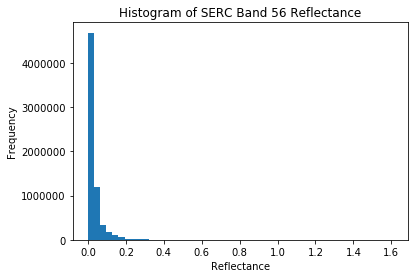

In [15]:
plt.hist(b56[~np.isnan(b56)],50);
plt.title('Histogram of SERC Band 56 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

## Plot single reflectance band

Now we can plot this band using the Python package ```matplotlib.pyplot```, which we imported at the beginning of the lesson as ```plt```. Note that the default colormap is jet unless otherwise specified. We will explore using different colormaps a little later. 

(0, 0.5)

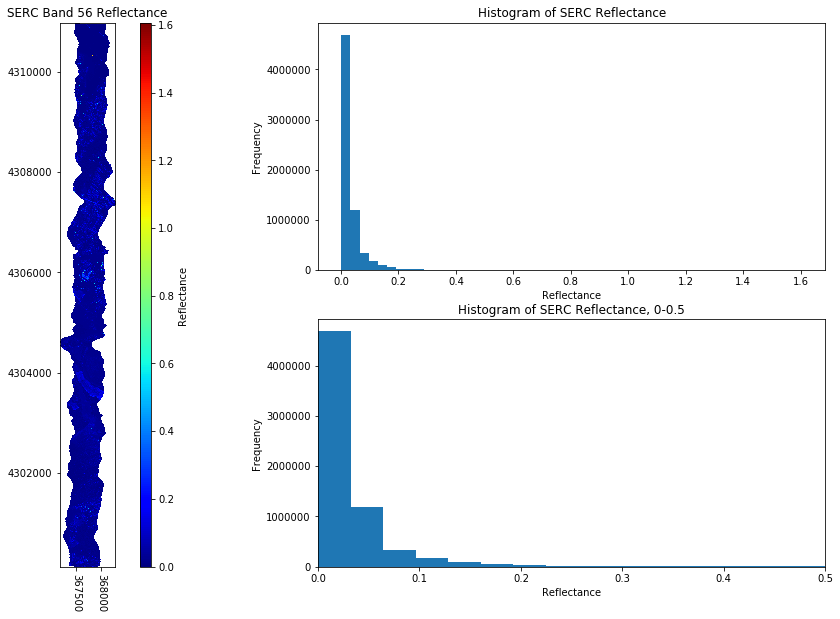

In [16]:
serc_fig = plt.figure(figsize=(20,10))
ax1 = serc_fig.add_subplot(1,2,1)
# serc_plot = ax1.imshow(b56,extent=serc_ext,cmap='jet',clim=(0,0.1)) 
serc_plot = ax1.imshow(b56,extent=serc_ext,cmap='jet') 
cbar = plt.colorbar(serc_plot,aspect=50); cbar.set_label('Reflectance')
plt.title('SERC Band 56 Reflectance'); #ax = plt.gca(); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=270) #rotate x tick labels 90 degree

#  plot histogram of reflectance values (with 50 bins)
ax2 = serc_fig.add_subplot(2,2,2)
ax2.hist(b56[~np.isnan(b56)],50); 
plt.title('Histogram of SERC Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

# plot histogram, zooming in on values < 0.5
ax3 = serc_fig.add_subplot(2,2,4)
ax3.hist(b56[~np.isnan(b56)],50); 
plt.title('Histogram of SERC Reflectance, 0-0.5')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')
ax3.set_xlim([0,0.5])

Note from both the plot and histogram of the reflectance values that almost all of the reflectance values range from 0.0-0.35. In order to see more contrast in the plot, we try out a couple things: 

1. adjust the color limits to only show the relevant range using the imshow clim option 
2. apply linear contrast stretch or histogram equalization 

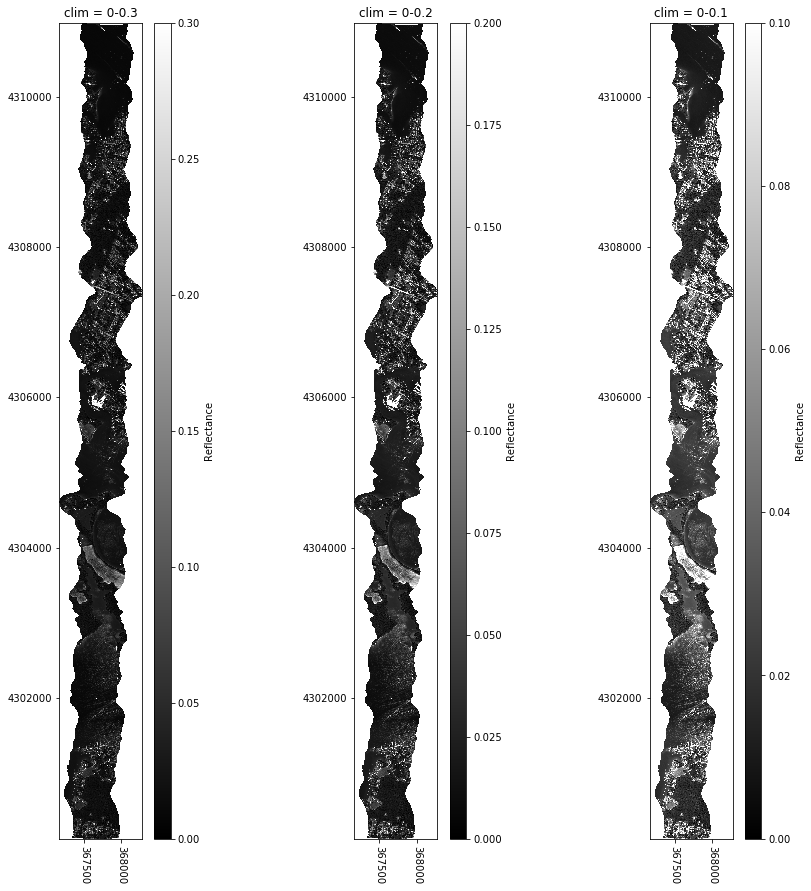

In [17]:
# Plot in grayscale with different color limits 
# Higher reflectance is lighter/brighter, lower reflectance is darker 
serc_fig2 = plt.figure(figsize=(15,15))
ax1 = serc_fig2.add_subplot(1,3,1)
serc_plot = ax1.imshow(b56,extent=serc_ext,cmap='gray',clim=(0,0.3)) 
cbar = plt.colorbar(serc_plot,aspect=50); cbar.set_label('Reflectance')
plt.title('clim = 0-0.3'); #ax = plt.gca(); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=270) #rotate x tick labels 90 degree

ax2 = serc_fig2.add_subplot(1,3,2)
serc_plot = ax2.imshow(b56,extent=serc_ext,cmap='gray',clim=(0,0.2)) 
cbar = plt.colorbar(serc_plot,aspect=50); cbar.set_label('Reflectance')
plt.title('clim = 0-0.2'); #ax = plt.gca(); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=270) #rotate x tick labels 90 degree

ax3 = serc_fig2.add_subplot(1,3,3)
serc_plot = ax3.imshow(b56,extent=serc_ext,cmap='gray',clim=(0,0.1)) 
cbar = plt.colorbar(serc_plot,aspect=50); cbar.set_label('Reflectance')
plt.title('clim = 0-0.1'); #ax = plt.gca(); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax3.get_xticklabels(),rotation=270) #rotate x tick labels 90 degree

## OPTIONAL: Plot a subset of the SERC flightline reflectance data

You may want to zoom in on a specific region within a flightline for further analysis. To do this, we need to subset the data, which requires the following steps:

1. Define the spatial extent of the data subset (or clip) that we want to zoom in on.
2. Determine the pixel indices of the full flightline that correspond to these spatial extents.
3. Subscript the full flightline array with these indices to create a subset.

For this exercise, we will zoom in on a region in the middle of this SERC flight line, around UTM y = 4306000 m. We will load the function ```calc_clip_index```, which reads in a dictionary of the spatial extent of the clipped region of interest, and a dictionary of the full extent of the array you are subsetting, and returns the pixel indices corresponding to the full flightline array. 

In [18]:
def calc_clip_index(clipExtent, fullExtent, xscale=1, yscale=1):
    
    h5rows = fullExtent['yMax'] - fullExtent['yMin']
    h5cols = fullExtent['xMax'] - fullExtent['xMin']    
    
    indExtent = {}
    indExtent['xMin'] = round((clipExtent['xMin']-fullExtent['xMin'])/xscale)
    indExtent['xMax'] = round((clipExtent['xMax']-fullExtent['xMin'])/xscale)
    indExtent['yMax'] = round(h5rows - (clipExtent['yMin']-fullExtent['yMin'])/xscale)
    indExtent['yMin'] = round(h5rows - (clipExtent['yMax']-fullExtent['yMin'])/yscale)

    return indExtent

In [19]:
#Define clip extent
clipExtent = {}
clipExtent['xMin'] = 367400
clipExtent['xMax'] = 368100
clipExtent['yMin'] = 4305750
clipExtent['yMax'] = 4306350

Use this function to find the indices corresponding to the clip extent that we specified above for SERC:

In [20]:
serc_subInd = calc_clip_index(clipExtent,serc_extDict)
print('SERC Subset Index:',serc_subInd)

SERC Subset Index: {'xMin': 233, 'xMax': 933, 'yMin': 4630, 'yMax': 5230}


We can now use these indices to create a subsetted array, with dimensions 600 x 700 x 426.

In [21]:
serc_subArray = serc_reflArray[serc_subInd['yMin']:serc_subInd['yMax'],serc_subInd['xMin']:serc_subInd['xMax'],:]
serc_subExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
print('SERC Reflectance Subset Dimensions:',serc_subArray.shape)

SERC Reflectance Subset Dimensions: (600, 700, 426)


Extract band 56 from this subset, and clean by applying the no data value and scale factor:

In [22]:
serc_b56_subset = serc_subArray[:,:,55].astype(np.float)
serc_b56_subset[serc_b56_subset==int(noDataValue)]=np.nan
serc_b56_subset = serc_b56_subset/scaleFactor
#print(serc_b56_subset)

Take a quick look at the minimum, maximum, and mean reflectance values in this subsetted area: 

In [23]:
print('SERC Subsetted Band 56 Reflectance Stats:')
print('min reflectance:',np.nanmin(serc_b56_subset))
print('mean reflectance:',round(np.nanmean(serc_b56_subset),2))
print('max reflectance:',round(np.nanmax(serc_b56_subset),2))

SERC Subsetted Band 56 Reflectance Stats:
min reflectance: 0.0
mean reflectance: 0.05
max reflectance: 1.59


Lastly, plot the data and a histogram of the reflectance values to see what the distribution looks like.

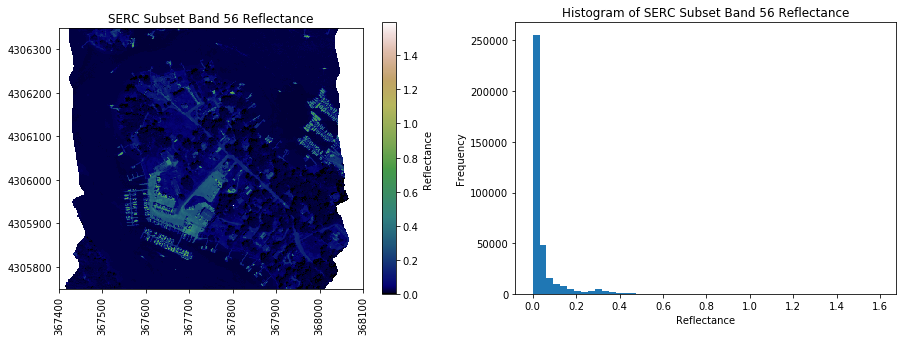

In [24]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
serc_subset_plot = plt.imshow(serc_b56_subset,extent=serc_subExt,cmap='gist_earth') 
cbar = plt.colorbar(serc_subset_plot); cbar.set_label('Reflectance')
plt.title('SERC Subset Band 56 Reflectance'); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

ax2 = fig.add_subplot(1,2,2)
plt.hist(serc_b56_subset[~np.isnan(serc_b56_subset)],50);
plt.title('Histogram of SERC Subset Band 56 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

## On Your Own: Test out different plot options to visualize the data

Note that most of the reflectance values are < 0.5, but the colorbar scale ranges from 0 - 1.6. This results in a low-contrast imagh; with this colormap, most of the image is blue, and the contents are difficult to discern. We can make a few simple plot adjustments to better display and visualize the reflectance data:

- Try out some other colormaps with the ```cmap``` option. For a list of colormaps, refer to: http://matplotlib.org/examples/color/colormaps_reference.html. *Note:* You can reverse the order of these colormaps by appending _r to the end (eg. spectral_r).
- Adjust the colorbar limits -- looking at the histogram, most of the reflectance data < 0.08, so you can adjust the maximum `clim` value for more visual contrast.

Some example plotting options are shown below:

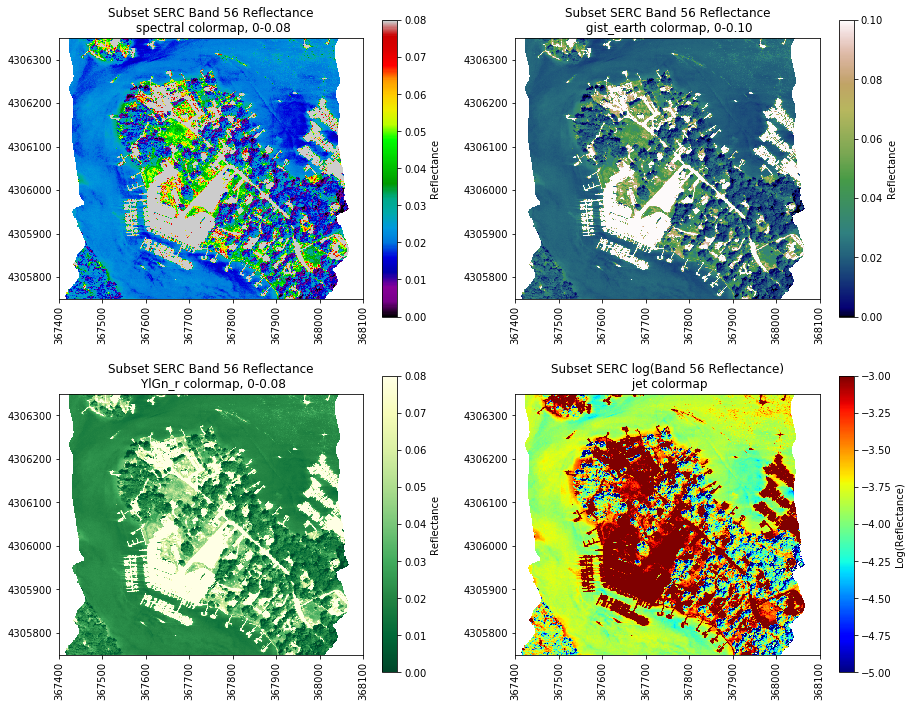

In [25]:
fig = plt.figure(figsize=(15,12))

#spectral Colormap, 0-0.08
ax1 = fig.add_subplot(2,2,1)
serc_subset_plot = plt.imshow(serc_b56_subset,extent=serc_subExt,cmap='spectral',clim=(0,0.08)) 
cbar = plt.colorbar(serc_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset SERC Band 56 Reflectance\n spectral colormap, 0-0.08'); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

#gist_earth colormap, 0-0.10
ax2 = fig.add_subplot(2,2,2)
serc_subset_plot = plt.imshow(serc_b56_subset,extent=serc_subExt,cmap='gist_earth',clim=(0,0.1)) 
cbar = plt.colorbar(serc_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset SERC Band 56 Reflectance\n gist_earth colormap, 0-0.10'); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

#YlGn_r colormap, 0-0.08
ax3 = fig.add_subplot(2,2,3)
serc_subset_plot = plt.imshow(serc_b56_subset,extent=serc_subExt,cmap='YlGn_r',clim=(0,0.08)) 
cbar = plt.colorbar(serc_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset SERC Band 56 Reflectance\n YlGn_r colormap, 0-0.08'); 
ax3.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax3.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

#For the last example, take the logarithm of the reflectance data to stretch the values:
serc_b56_subset_log = np.log(serc_b56_subset); 
ax4 = fig.add_subplot(2,2,4)
serc_subset_plot = plt.imshow(serc_b56_subset_log,extent=serc_subExt,cmap='jet',clim=(-5,-3)) 
cbar = plt.colorbar(serc_subset_plot); cbar.set_label('Log(Reflectance)')
plt.title('Subset SERC log(Band 56 Reflectance)\n jet colormap'); 
ax4.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax4.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

## OPTIONAL: Basic Image Processing -- Contrast Stretch & Histogram Equalization 

We can also try out some basic image processing to better visualize the reflectance data using the ```ski-image``` package. 

Histogram equalization is a method in image processing of contrast adjustment using the image's histogram. Stretching the histogram can improve the contrast of a displayed image, as we will show how to do below. 

<p>
<img src="histogram_equalization.png" style="width: 300px;"/>
</p>

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

These tutorials were adapted from the following `skikit-image` tutorial:
http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py

Let's start with trying a 2% and 5% linear contrast stretch:

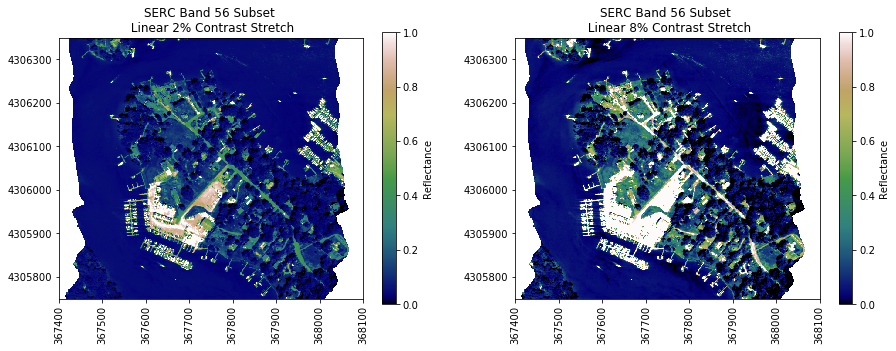

In [26]:
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(serc_b56_subset[~np.isnan(serc_b56_subset)], (2, 98))
img_rescale2pct = exposure.rescale_intensity(serc_b56_subset, in_range=(p2, p98))

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
plt.imshow(img_rescale2pct,extent=serc_subExt,cmap='gist_earth') 
cbar = plt.colorbar(); cbar.set_label('Reflectance')
plt.title('SERC Band 56 Subset \n Linear 2% Contrast Stretch'); 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

p8, p92 = np.percentile(serc_b56_subset[~np.isnan(serc_b56_subset)], (8, 92))
img_rescale8pct = exposure.rescale_intensity(serc_b56_subset, in_range=(p8, p92))

ax2 = fig.add_subplot(1,2,2)
plt.imshow(img_rescale8pct,extent=serc_subExt,cmap='gist_earth') 
cbar = plt.colorbar(); cbar.set_label('Reflectance')
plt.title('SERC Band 56 Subset \n Linear 8% Contrast Stretch'); 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

Notice that the 8% stretch image (right) washes out some of the objects with higher reflectance (eg. the dock & buildings), but does a better job showing contrast of the vegetation (eg. grass, trees, shadows). 

### Explore the contrast stretch feature interactively using Python widgets: 

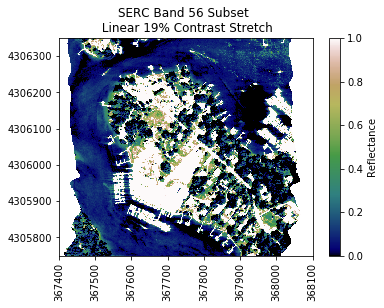

In [27]:
from IPython.html.widgets import *

def linearStretch(percent):
    pLow, pHigh = np.percentile(serc_b56_subset[~np.isnan(serc_b56_subset)], (percent,100-percent))
    img_rescale = exposure.rescale_intensity(serc_b56_subset, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=serc_subExt,cmap='gist_earth') 
    cbar = plt.colorbar(); cbar.set_label('Reflectance')
    plt.title('SERC Band 56 Subset \n Linear ' + str(percent) + '% Contrast Stretch'); 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree
    
interact(linearStretch,percent=(0,100,1))

### Apply Adaptive Histogram Equalization to Improve Image Contrast

img_adapteq min: 0.0
img_adapteq max: 1.0


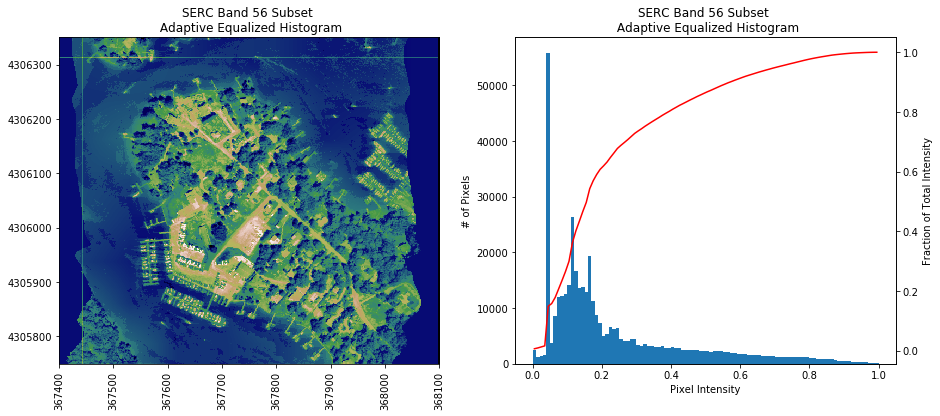

In [28]:
#Adaptive Equalized Histogram
img_nonan = np.ma.masked_invalid(serc_b56_subset) #first mask the image 
img_adapteq = exposure.equalize_adapthist(img_nonan, clip_limit=.05)
print('img_adapteq min:',np.min(img_adapteq)) 
print('img_adapteq max:',np.max(img_adapteq))

# Display Adaptively Equalized Image
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_adapteq,extent=serc_subExt,cmap='gist_earth') 
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree
plt.title('SERC Band 56 Subset \n Adaptive Equalized Histogram'); 

# Display histogram
bins=100
ax_hist = fig.add_subplot(1,2,2)
ax_hist.hist(img_adapteq.ravel(),bins); #np.ravel flattens an array into one dimension
plt.title('SERC Band 56 Subset \n Adaptive Equalized Histogram'); 
ax_hist.set_xlabel('Pixel Intensity'); ax_hist.set_ylabel('# of Pixels')

# Display cumulative distribution
ax_cdf = ax_hist.twinx()
img_cdf, bins = exposure.cumulative_distribution(img_adapteq,bins)
ax_cdf.plot(bins, img_cdf, 'r')
ax_cdf.set_ylabel('Fraction of Total Intensity')

With contrast-limited adaptive histogram equalization, you can see more detail in the image, and the highly reflective objects are not washed out, as they were in the linearly-stretched images. 